# Camera position optimization using differentiable rendering

In this tutorial we will learn the [x, y, z] position of a camera given a reference image using differentiable rendering. 

We will first initialize a renderer with a starting position for the camera. We will then use this to generate an image, compute a loss with the reference image, and finally backpropagate through the entire pipeline to update the position of the camera. 

This tutorial shows how to:
- load a mesh from an `.obj` file
- initialize a `Camera`, `Shader` and `Renderer`,
- render a mesh
- set up an optimization loop with a loss function and optimizer


##  0. Install and import modules

Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [ ]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.13.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 KB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 KB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61431 sha256=fc302d6bb4f95b4ab8a294f8198a8cada7660cb7ac65e023ad21c48e9da403c0
  Stored in directory: /root/.cache/pip/wheels/b8/79/07/c0e9367f5b5ea325e246bd73651e8af175fabbef943043b1cc
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31547 sha256=b3246d0c920c040ba63b223fb14520b63ec2b226222899067e4ea9d311e3abf8
  Stored in directory: /root/.cache/pip/wheels/89/3e/24/0f349c0b2eeb6965903035f3b00dbb5c9bea437b4a2f18d82c
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py38_cu116_pyt1131/dow

In [ ]:
import os
import torch
import numpy as np
from tqdm.notebook import tqdm
import imageio
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage import img_as_ubyte

# io utils
from pytorch3d.io import load_obj

# datastructures
from pytorch3d.structures import Meshes

# 3D transformations functions
from pytorch3d.transforms import Rotate, Translate

# rendering components
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
)

## 1. Load the Obj

We will load an obj file and create a **Meshes** object. **Meshes** is a unique datastructure provided in PyTorch3D for working with **batches of meshes of different sizes**. It has several useful class methods which are used in the rendering pipeline. 

If you are running this notebook locally after cloning the PyTorch3D repository, the mesh will already be available. **If using Google Colab, fetch the mesh and save it at the path `data/`**:

In [ ]:
!wget -P data https://web.mit.edu/djwendel/www/weblogo/shapes/vehicles/truck/truck.obj

--2023-01-28 16:27:11--  https://web.mit.edu/djwendel/www/weblogo/shapes/vehicles/truck/truck.obj
Resolving web.mit.edu (web.mit.edu)... 23.199.138.122, 2600:1417:3f:bb3::255e, 2600:1417:3f:b97::255e
Connecting to web.mit.edu (web.mit.edu)|23.199.138.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46241 (45K) [text/plain]
Saving to: ‘data/truck.obj’

truck.obj           100%[===================>]  45.16K  --.-KB/s    in 0.01s   

2023-01-28 16:27:11 (3.54 MB/s) - ‘data/truck.obj’ saved [46241/46241]



In [ ]:
!wget -P data https://raw.githubusercontent.com/kks32/3dmesh/main/car.obj

--2023-01-28 16:27:13--  https://raw.githubusercontent.com/kks32/3dmesh/main/car.obj
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1562438 (1.5M) [text/plain]
Saving to: ‘data/car.obj’

car.obj             100%[===================>]   1.49M  --.-KB/s    in 0.008s  

2023-01-28 16:27:13 (189 MB/s) - ‘data/car.obj’ saved [1562438/1562438]



In [ ]:
# Set the cuda device 
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Load the obj and ignore the textures and materials.
verts, faces_idx, _ = load_obj("./data/truck.obj")
faces = faces_idx.verts_idx

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = TexturesVertex(verts_features=verts_rgb.to(device))

# Create a Meshes object for the teapot. Here we have only one mesh in the batch.
mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)

/usr/local/lib/python3.8/dist-packages/pytorch3d/io/obj_io.py:546: UserWarning: Mtl file does not exist: ./data/truck.mtl
  warnings.warn(f"Mtl file does not exist: {f}")




## 2. Optimization setup

### Create a renderer

A **renderer** in PyTorch3D is composed of a **rasterizer** and a **shader** which each have a number of subcomponents such as a **camera** (orthographic/perspective). Here we initialize some of these components and use default values for the rest. 

For optimizing the camera position we will use a renderer which produces a **silhouette** of the object only and does not apply any **lighting** or **shading**. We will also initialize another renderer which applies full **Phong shading** and use this for visualizing the outputs. 

In [ ]:
# Initialize a perspective camera.
cameras = FoVPerspectiveCameras(device=device)

# To blend the 100 faces we set a few parameters which control the opacity and the sharpness of 
# edges. Refer to blending.py for more details. 
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 256x256. To form the blended image we use 100 faces for each pixel. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=100, 
)

# Create a silhouette mesh renderer by composing a rasterizer and a shader. 
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)


# We will also create a Phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)
# We can add a point light in front of the object. 
lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(device=device, cameras=cameras, lights=lights)
)

### Create a reference image

We will first position the teapot and generate an image. We use helper functions to rotate the teapot to a desired viewpoint. Then we can use the renderers to produce an image. Here we will use both renderers and visualize the silhouette and full shaded image. 

The world coordinate system is defined as +Y up, +X left and +Z in. The teapot in world coordinates has the spout pointing to the left. 

We defined a camera which is positioned on the positive z axis hence sees the spout to the right. 

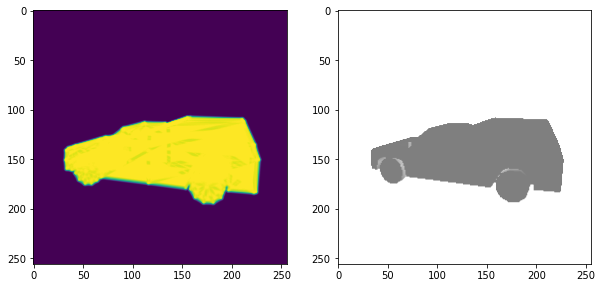

In [ ]:
# Select the viewpoint using spherical angles  
distance = 300  # distance from camera to the object
elevation = 10.0   # angle of elevation in degrees
azimuth = 20.0  # No rotation so the camera is positioned on the +Z axis. 

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

# Render the teapot providing the values of R and T. 
silhouette = silhouette_renderer(meshes_world=mesh, R=R, T=T)
image_ref = phong_renderer(meshes_world=mesh, R=R, T=T)

silhouette = silhouette.cpu().numpy()
image_ref = image_ref.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(silhouette.squeeze()[..., 3])  # only plot the alpha channel of the RGBA image
plt.grid(False)
plt.subplot(1, 2, 2)
plt.imshow(image_ref.squeeze())
plt.grid(False)

### Set up a basic model 

Here we create a simple model class and initialize a parameter for the camera position. 

In [ ]:
class Model(nn.Module):
    def __init__(self, meshes, renderer, image_ref):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderer = renderer
        
        # Get the silhouette of the reference RGB image by finding all non-white pixel values. 
        image_ref = torch.from_numpy((image_ref[..., :3].max(-1) != 1).astype(np.float32))
        self.register_buffer('image_ref', image_ref)
        
        # Create an optimizable parameter for the x, y, z position of the camera. 
        self.camera_position = nn.Parameter(
            torch.from_numpy(np.array([300.0,  15.0, +5], dtype=np.float32)).to(meshes.device))

    def forward(self):
        
        # Render the image using the updated camera position. Based on the new position of the 
        # camera we calculate the rotation and translation matrices
        R = look_at_rotation(self.camera_position[None, :], device=self.device)  # (1, 3, 3)
        T = -torch.bmm(R.transpose(1, 2), self.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        
        image = self.renderer(meshes_world=self.meshes.clone(), R=R, T=T)
        
        # Calculate the silhouette loss
        loss = torch.sum((image[..., 3] - self.image_ref) ** 2)
        return loss, image
  

## 3. Initialize the model and optimizer

### Visualize the starting position and the reference position

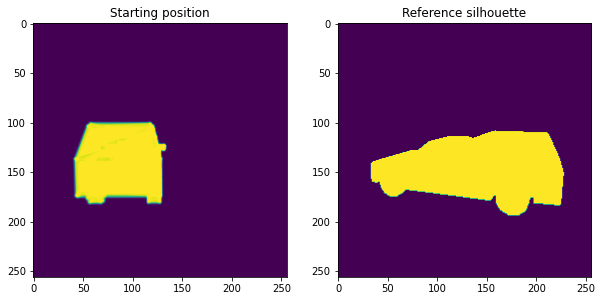

In [ ]:
plt.figure(figsize=(10, 10))

_, image_init = model()
plt.subplot(1, 2, 1)
plt.imshow(image_init.detach().squeeze().cpu().numpy()[..., 3])
plt.grid(False)
plt.title("Starting position")

plt.subplot(1, 2, 2)
plt.imshow(model.image_ref.cpu().numpy().squeeze())
plt.grid(False)
plt.title("Reference silhouette");


## 4. Run the optimization 

We run several iterations of the forward and backward pass and save outputs every 10 iterations. When this has finished take a look at `./teapot_optimization_demo.gif` for a cool gif of the optimization process!


Now we can create an instance of the **model** above and set up an **optimizer** for the camera position parameter. 

In [ ]:
# We will save images periodically and compose them into a GIF.
filename_output = "./truck_optimization_demo.gif"
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

# Initialize a model using the renderer, mesh and reference image
model = Model(meshes=mesh, renderer=silhouette_renderer, image_ref=image_ref).to(device)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

  0%|          | 0/2000 [00:00<?, ?it/s]

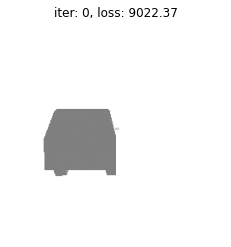

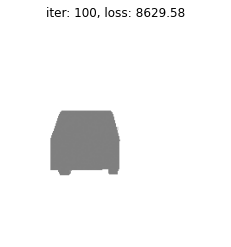

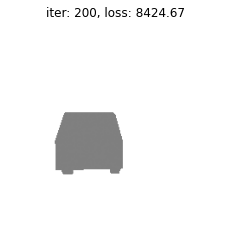

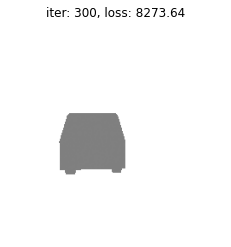

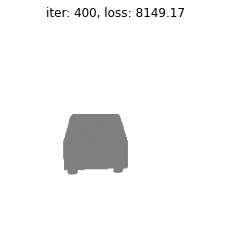

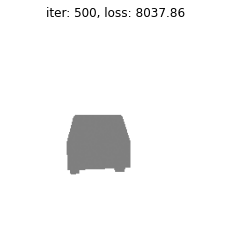

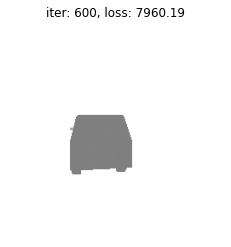

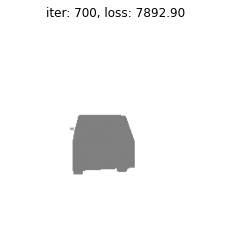

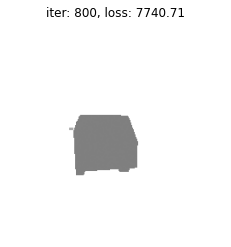

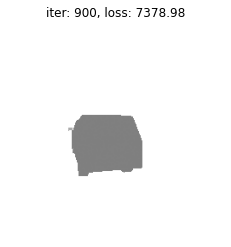

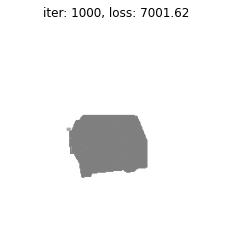

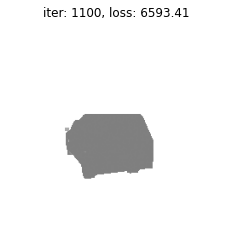

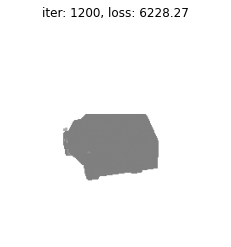

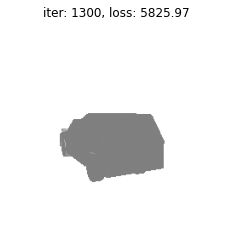

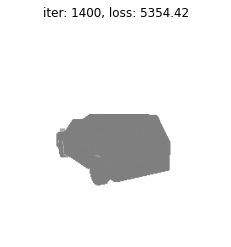

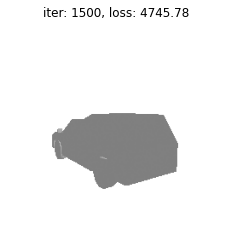

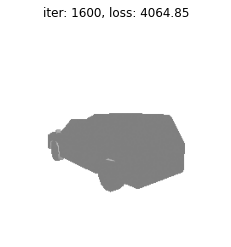

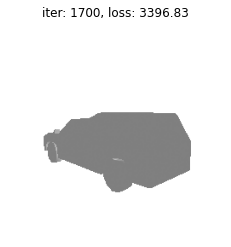

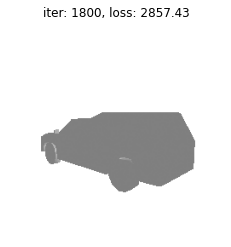

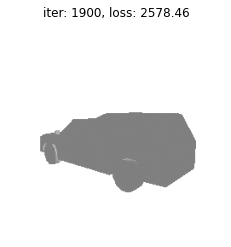

In [ ]:
nsteps = 2000
nout_steps = 100
loop = tqdm(range(nsteps))
for i in loop:
    optimizer.zero_grad()
    loss, _ = model()
    loss.backward()
    optimizer.step()
    
    loop.set_description('Optimizing (loss %.4f)' % loss.data)
    
    if loss.item() < nsteps:
        break
    
    # Save outputs to create a GIF. 
    if i % nout_steps == 0:
        R = look_at_rotation(model.camera_position[None, :], device=model.device)
        T = -torch.bmm(R.transpose(1, 2), model.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        image = phong_renderer(meshes_world=model.meshes.clone(), R=R, T=T)
        image = image[0, ..., :3].detach().squeeze().cpu().numpy()
        image = img_as_ubyte(image)
        writer.append_data(image)
        
        plt.figure()
        plt.imshow(image[..., :3])
        plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
        plt.axis("off")
    
writer.close()

## 5. Conclusion 

In this tutorial we learnt how to **load** a mesh from an obj file, initialize a PyTorch3D datastructure called **Meshes**, set up an **Renderer** consisting of a **Rasterizer** and a **Shader**, set up an optimization loop including a **Model** and a **loss function**, and run  the optimization. 